### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Aditya Desu

**Student ID:**     1000447

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


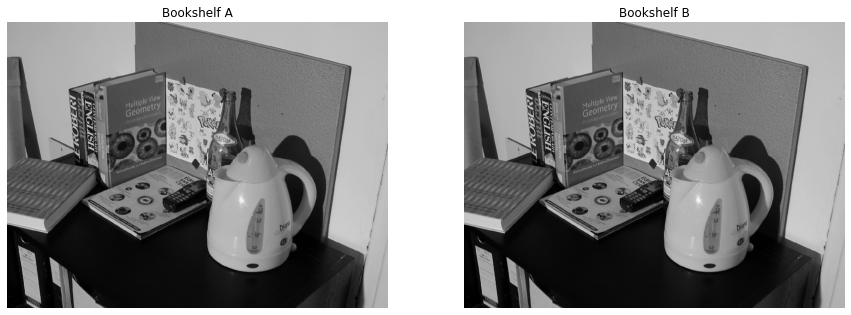

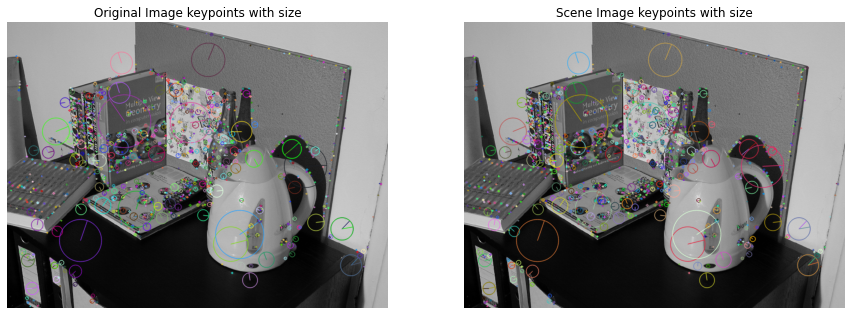

Number of keypoints detected in the Scene image:  1265
[  4 322] [  4 322]
[  4 322] [  4 322]
[  6 369] [  6 369]
[  7 338] [  7 338]
[ 10 329] [ 10 329]
[ 10 329] [ 10 329]
[18 68] [18 68]
[ 19 374] [ 19 374]


In [58]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
# Load images
data_dir = '/Users/adityadesu/Documents/Computer Vision/Assignment 3/kusvod2'

bookshelfA = cv2.imread(os.path.join(data_dir, 'bookshA.png'), cv2.IMREAD_GRAYSCALE)
bookshelfB = cv2.imread(os.path.join(data_dir, 'bookshA.png'), cv2.IMREAD_GRAYSCALE)

# Convert to colour space
#bookshelfA = cv2.cvtColor(bookshelfA, cv2.COLOR_BGR2RGB)
#bookshelfB = cv2.cvtColor(bookshelfB, cv2.COLOR_BGR2RGB)

# Display original image and scene image
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(bookshelfA, cmap='gray') 
plt.title('Bookshelf A')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(bookshelfB, cmap='gray')
plt.title('Bookshelf B')
plt.axis('off')

plt.show() 

# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(bookshelfA,None)
kp2, des2 = sift.detectAndCompute(bookshelfB,None)

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(bookshelfA,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(bookshelfB,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplots(figsize=(15, 15)) 
plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Original Image keypoints with size')
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Scene Image keypoints with size')
plt.axis('off')
plt.show() 

print("Number of keypoints detected in the Scene image: ", len(kp2))

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 *n.distance: 
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)



ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)


for i in range(len(ptsL)):
    print(ptsL[i], ptsR[i])
    if i == 7:
        break




### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [62]:
def normalize(pts):
    ''' Shift and transform points to have root 2 mean and unit variance '''
    n = len(pts)
    centroid = np.mean(pts, axis=0)
    centered_coords = pts - centroid
    scaling_f = n*np.sqrt(2)/np.sum(np.linalg.norm(centered_coords, axis=1))
    T = np.array([[scaling_f, 0, -scaling_f*centroid[0]], 
                [0, scaling_f, -scaling_f*centroid[1]], 
                [0, 0, 1]])
    normalised_pts = np.dot(T, np.concatenate((pts.T, np.ones((1, n))), axis=0))
    return normalised_pts.T, T

ptsL_normalised, T1 = normalize(ptsL)
ptsR_normalised, T2 = normalize(ptsR)


def get_design_matrix(ptsL, ptsR, idx):
    ''' Return a design matrix for the 8 point algorithm '''
    n = len(idx)
    
    
    A = np.zeros((n, 9))
    for i in idx:
        design_matrix_row = np.array([ptsL[i, 0]*ptsR[i, 0], ptsL[i, 1]*ptsR[i, 0], ptsL[i, 0], 
                   ptsL[i, 0]*ptsR[i, 1], ptsL[i, 1]*ptsR[i, 1], ptsL[i, 1], 
                   ptsR[i, 0], ptsR[i, 1], 1])

        A[i] = design_matrix_row
        
    return A

def get_fundamental_matrix(ptsL, ptsR):
    ''' Return the fundamental matrix using the 8 point algorithm '''
    n = len(ptsL)
    A = get_design_matrix(ptsL, ptsR, n)
    U, S, V = np.linalg.svd(A)
    F = V[-1, :].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    return F


def compute_epilines(F, pts, inliers):
    ''' Return the epilines for a given set of F, points and inliers '''
    epilines = []
    for i in inliers:
        x = np.array([pts[i, 0], pts[i, 1], 1])
    
        epiline = np.dot(F, x)
        epilines.append(epiline)
    return np.array(epilines)

# Compute inlers and outliers
def get_inliers_outliers(ptsL, ptsR, F, threshold):
    ''' Return inliers and outliers given a fundamental matrix, a threshold and a set of points '''
    inliers = []
    outliers = []
    epipolar_lines_left = []
    epipolar_lines_right = []

    for i in range(len(ptsL)):
        x1 = np.array([ptsL[i, 0], ptsL[i, 1], 1])
        x2 = np.array([ptsR[i, 0], ptsR[i, 1], 1])
        # Compute epipolar line for both images
        epipolar_line_left = np.dot(F, x2)
        epipolar_line_right = np.dot(F.T, x1)
        epipolar_lines_left.append(epipolar_line_left)
        epipolar_lines_right.append(epipolar_line_right)

        a, b, c = epipolar_line_left

        # Compute distance from point to epipolar line
        d1 = abs(x1 @ epipolar_line_left) / np.linalg.norm(epipolar_line_left[:2])
        d2 = abs(a * x2[0] + b * x2[1] + c) / (np.sqrt(a**2 + b**2))
        if d1 < threshold:
            inliers.append(i)
        else:
            outliers.append(i)
    
    return inliers, outliers

A = get_design_matrix(ptsL_normalised, ptsR_normalised, [0,1,2,3,4,5,6,7])

U, S, V = np.linalg.svd(A)
draft_F = V[-1, :].reshape(3, 3)
print("Determinant of draft F before setting the smallest singular value to 0:", np.linalg.det(draft_F))
U, S, V = np.linalg.svd(draft_F)
S[-1] = 0
draft_F = np.dot(U, np.dot(np.diag(S), V))
print("Determinant of draft F after setting smallest singular value to 0:", np.linalg.det(draft_F))
print("Reassembled F:\n", draft_F)

# Rescale the fundamental matrix
F = T2.T @ draft_F @ T1
print("Determinant of F after rescaling", np.linalg.det(F))
print("Rescaled F:\n", F)

# Compute inliers and outliers
inliers, outliers = get_inliers_outliers(ptsL, ptsR, F, 5)
print("Number of inliers:", len(inliers))
print("Number of outliers:", len(outliers))

Determinant of draft F before setting the smallest singular value to 0: -2.3626643418173946e-18
Determinant of draft F after setting smallest singular value to 0: 0.0
Reassembled F:
 [[ 2.38154989e-19  3.94402015e-04  5.96426204e-04]
 [-3.94402015e-04 -2.22044605e-16 -7.07106420e-01]
 [-5.96426204e-04  7.07106420e-01  2.22044605e-16]]
Determinant of F after rescaling 0.0
Rescaled F:
 [[ 1.64974356e-23  2.73209555e-08 -2.35296745e-06]
 [-2.73209555e-08 -1.53814396e-20 -5.87703361e-03]
 [ 2.35296745e-06  5.87703361e-03 -1.77635684e-15]]
Number of inliers: 1265
Number of outliers: 0


### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

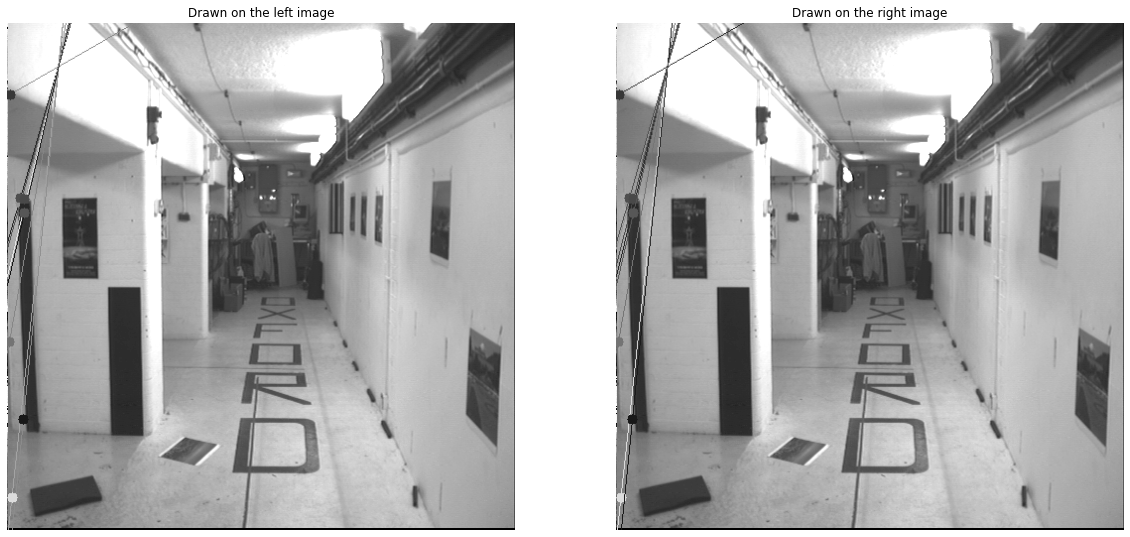

In [57]:

# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    
    r,c = img1.shape[:2]
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2
inliers_array = np.array(inliers)





linesL = compute_epilines(F, ptsL, inliers_array)
#linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(bookshelfB, bookshelfA, linesL[:10], ptsL[inliers[0:10]], ptsR[inliers[0:10]])

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = compute_epilines(F.T, ptsR, inliers_array)
#linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(bookshelfA, bookshelfB, linesR[:10], ptsR[inliers[:10]], ptsL[inliers[:10]])

# Display the results
plt.subplots(figsize=(20, 20)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show()

In [ ]:
Determinant of draft F before setting the smallest singular value to 0 0.01775090734658753
Determinant of draft F after setting smallest singular value to 0 -1.019700809537589e-17
Reassembled F:
 [[-0.00745451 -0.2730524  -0.29231574]
 [ 0.31491797 -0.00640091 -0.53701399]
 [ 0.33525935  0.57648981  0.07954807]]
Determinant of F after rescaling 0.0
Rescaled F:
 [[  -88.03992321 -3224.82882349 -7009.69889716]
 [ 3719.27343068   -75.59661692  8868.32845772]
 [ 7254.29329831 -7949.31638908   855.66363194]]